In [89]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [91]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [104]:
scores = scores[(scores != 0).all(1)]

In [93]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [94]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [95]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

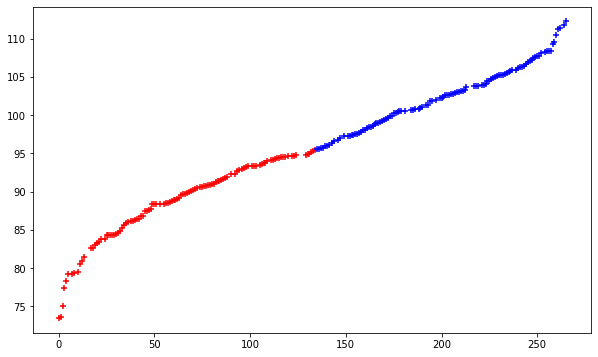

In [96]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [121]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])

Skopje -> 97


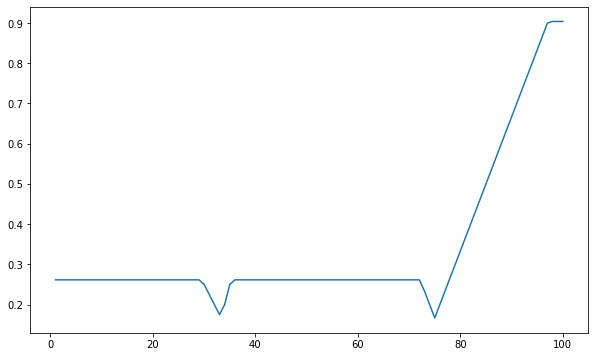

Singapore -> 94


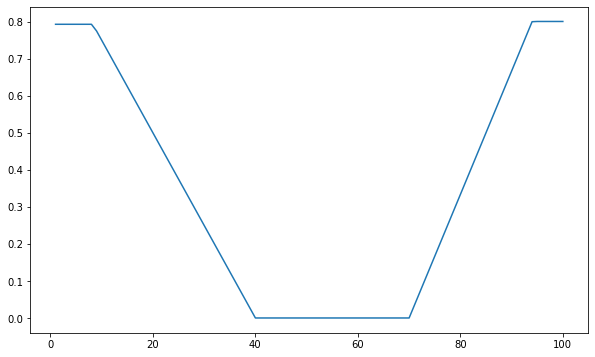

Thessaloniki -> 93


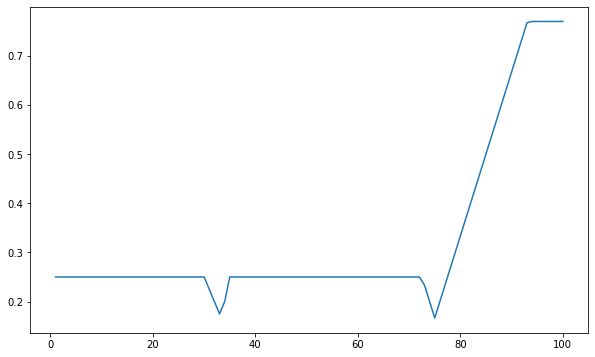

Porto -> 1


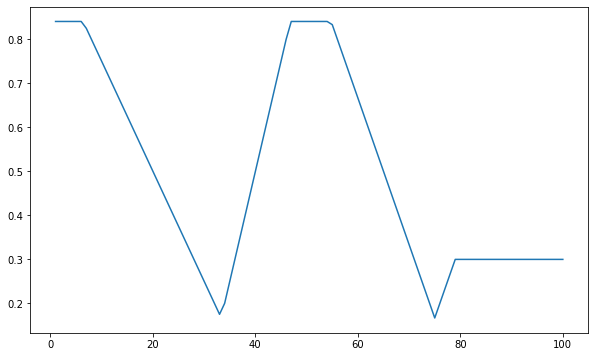

Bengaluru -> 99


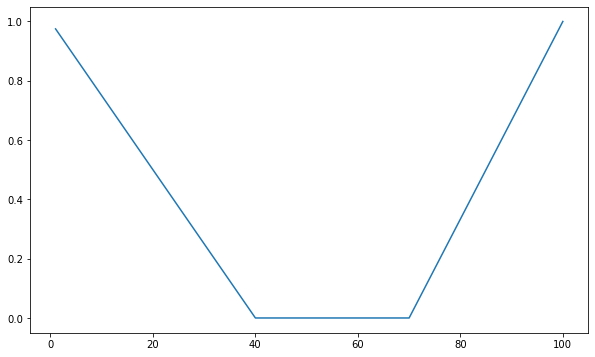

In [135]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TriangularFunction
from Modules.norms import AdditiveNorm
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_antecedent('Housing', 'Mid', TriangularFunction(0.3, 0.4, 0.8))
fuzzy.add_antecedent('Housing', 'Good', TriangularFunction(0.7, 1, 1))

fuzzy.add_antecedent('Startups', 'Bad', TriangularFunction(0, 0, 0.3))
fuzzy.add_antecedent('Startups', 'Mid', TriangularFunction(0.2, 0.4, 0.6))
fuzzy.add_antecedent('Startups', 'Good', TriangularFunction(0.5, 1, 1))

fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Bad'}, 'Bad')
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Mid'}, 'Bad')
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Good'}, 'Bad')
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Bad'}, 'Mid')
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Mid'}, 'Mid')
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Good'}, 'Good')
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Bad'}, 'Good')
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Mid'}, 'Good')
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Good'}, 'Good')

fuzzy.add_consequent('Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_consequent('Mid', TriangularFunction(0.3, 0.5, 0.8))
fuzzy.add_consequent('Good', TriangularFunction(0.7, 1, 1))

for i in range(5):
    sample = a.iloc[i]
    result, fx = fuzzy.compute(sample, 'fom')
    print(f'{sample["UA_Name"]} -> {result}')

    xs = np.linspace(1, 100, num=100)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    ax.plot(xs, fx)
    plt.show()


In [134]:
scores[scores.UA_Name == 'Singapore']

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Travel Connectivity,Commute,Business Freedom,Safety,...,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Naive Sum,Label
226,Singapore,Singapore,Asia,1.745,3.489,9.103,2.982,5.42725,9.724667,9.9715,...,8.2465,7.95425,7.4785,9.959,8.447,7.4225,6.495,5.834,108.443233,better


In [100]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TrapezoidalFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TrapezoidalFunction(0, 0.2, 0.4, 0.6))
fuzzy.add_antecedent('Housing', 'Mid', TrapezoidalFunction(0.1, 0.3, 0.5, 0.7))
fuzzy.add_antecedent('Housing', 'Good', TrapezoidalFunction(0.3, 0.5, 0.7, 1))

fuzzy.add_antecedent('Startups', 'Bad', TrapezoidalFunction(0, 0.3, 0.6, 0.9))
fuzzy.add_antecedent('Startups', 'Mid', TrapezoidalFunction(0.1, 0.4, 0.7, 1))
fuzzy.add_antecedent('Startups', 'Good', TrapezoidalFunction(0.05, 0.25, 0.45, 0.65))

for i in range(5):
    sample = a.iloc[i].to_dict()
    fuzzified_sample = fuzzy.fuzzify(sample)
    print(f'{sample["UA_Name"]} -> {fuzzified_sample}')

Hannover -> {'Housing': {'linguistic': 'Good', 'numerical': 0.8318518518518513}, 'Startups': {'linguistic': 'Bad', 'numerical': 0}}
Asheville -> {'Housing': {'linguistic': 'Good', 'numerical': 1}, 'Startups': {'linguistic': 'Good', 'numerical': 1}}
Eindhoven -> {'Housing': {'linguistic': 'Good', 'numerical': 1}, 'Startups': {'linguistic': 'Good', 'numerical': 1}}
Curitiba -> {'Housing': {'linguistic': 'Good', 'numerical': 0.21129629629629607}, 'Startups': {'linguistic': 'Good', 'numerical': 0.8122222222222222}}
Karlsruhe -> {'Housing': {'linguistic': 'Good', 'numerical': 0.8279629629629636}, 'Startups': {'linguistic': 'Good', 'numerical': 0.8577777777777779}}
